(fft_2d)=
# 2d fft  -- satellite optical depth

## 2D histogram of the optical depth $\tau$

Below I calculate the 2-d and averaged 1-d spectra for the optical depth, which gives the penetration
depth of photons through a cloud, and is closely related to cloud thickness. Follows
[Lewis et al., 2004](http://onlinelibrary.wiley.com/doi/10.1029/2003JD003742/full)

In [1]:
from numba import jit
from pathlib import Path
from matplotlib import pyplot as plt
import xarray as xr
from timeit import default_timer as timer

In [2]:
scene_file = Path.home() / "Dropbox/phil_files/a500/notebooks"
scene_file = list(scene_file.glob("**/a17.nc"))[0]
print(scene_file)

/Users/phil/Dropbox/phil_files/a500/notebooks/a17.nc


In [3]:
the_ds = xr.open_dataset(scene_file)
the_ds

<xarray.Dataset>
Dimensions:  (scanlines: 2048, pixels: 2048)
Dimensions without coordinates: scanlines, pixels
Data variables:
    tau      (scanlines, pixels) float32 ...
Attributes:
    date:      [1992    6   21]
    filename:  scene51.od

In [4]:
tau = the_ds['tau'].data
tau.shape

(2048, 2048)

## Character of the optical depth field

The image below shows one of the marine boundary layer landsat scenes analyzed in
[Lewis et al., 2004](http://onlinelibrary.wiley.com/doi/10.1029/2003JD003742/full)

It is a 2048 x 2048 pixel image taken by Landsat 7, with the visible reflectivity converted to
cloud optical depth.   The pixels are 25 m x 25 m, so the scene extends for about 50 km x 50 km

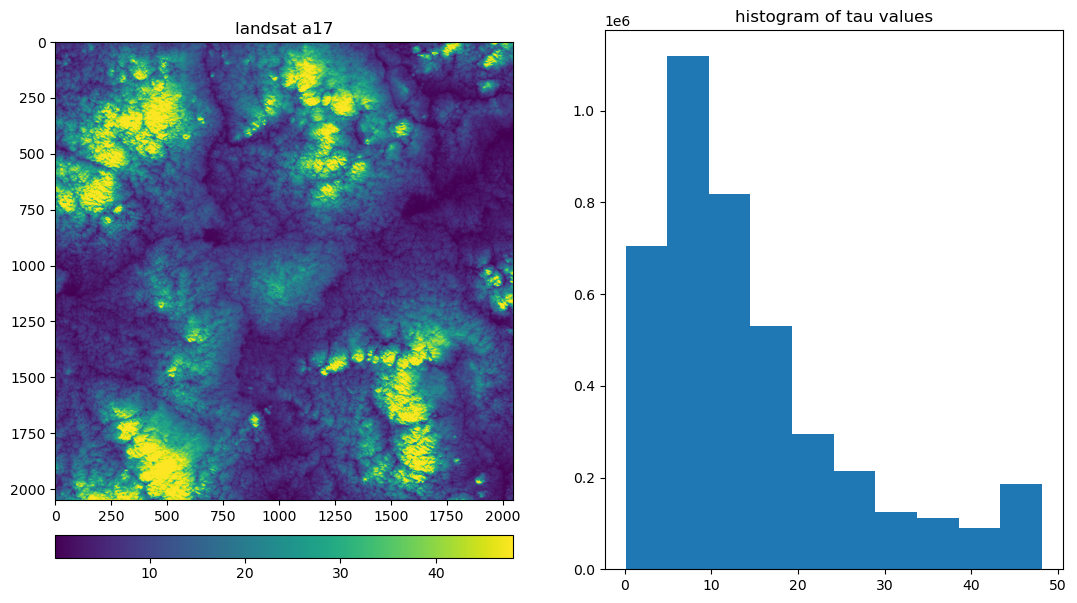

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 2, figsize=(13, 7))
ax[0].set_title("landsat a17")
im0 = ax[0].imshow(tau)
im1 = ax[1].hist(tau.ravel())
ax[1].set_title("histogram of tau values")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("bottom", size="5%", pad=0.35)
out = fig.colorbar(im0, orientation="horizontal", cax=cax)

## ubc_fft class

In the next cell I define a class that calculates the 2-d fft for a square image

We also define two free functions: 1) `power_spectrum` which calculates both the 2d fft and the power spectrum
and save them as class attributes.  In the function `annular_average` I take the power spectrum,
which is the two-dimensional field  $E(k_x, k_y)$ (in cartesian coordinates) or $E(k,\theta)$ (in polar coordinates).
In the function `annular_avg` I take the average

$$
\overline{E}(k) = \int_0^{2\pi} E(k, \theta) d\theta
$$

and plot that average with the method ```graph_spectrum```



In [6]:
from netCDF4 import Dataset
import numpy as np
import math
from numpy import fft
from matplotlib import pyplot as plt


class ubc_fft:
    def __init__(self, filename, var, scale):
        """
        
            Parameters
            -----------
            
            filename: string or Path
               full path to file
            varname: string
               netcdf variable name
            scale: float
               size of pixel in km

           Constructer opens the netcdf file, reads the data and
           saves the twodimensional fft
        """
        the_ds = xr.open_dataset(filename)
        data = the_ds[var].data
        data = data - data.mean()
        if data.shape[0] != data.shape[1]:
            raise ValueError("expecting square matrix")
        self.xdim = data.shape[0]  # size of each row of the array
        delta_k = 1.0 / scale  # 1./km (1/0.025 for landsat 25 meter pixels)
        self.nyquist = delta_k * 0.5
        self.midpoint = int(math.floor(self.xdim / 2))
        k_vals = np.arange(0, (self.midpoint)) + 1
        self.scale = float(scale)
        self.k_vals = (k_vals - self.midpoint) / (self.xdim * self.scale)
        self.filename = filename.stem
        self.var = var
        self.data = data
        self.fft_data = fft.fft2(self.data)

In [7]:
def power_spectrum(fft_obj):
    """
       calculate the power spectrum for the 2-dimensional field
       
       Parameters
       ----------

       fft_obj: instance of ubc_fft class

       Returns
       -------

       spectral_dens: ndarray
          2-dimensional spectral density after shifting low wavenumbers/long wavelengths
          to center
    """
    #
    # fft_shift moves the zero frequency point to the  middle
    # of the array
    #
    fft_shift = fft.fftshift(fft_obj.fft_data)
    spectral_dens = fft_shift * np.conjugate(fft_shift) / (fft_obj.xdim * fft_obj.xdim)
    spectral_dens = spectral_dens.real
    return spectral_dens

### This function computes the annular average

To speed up annular average loop, I use the [numba just in time compiler](https://pythonspeed.com/articles/numba-faster-python/).  The annular average
is given by bins that are oriented along the $\vec{k}$ radius, where $k^2 = k_x^2 + k_y^2$

In [8]:
@jit(nopython=True)
def annular_avg(spectral_dens, avg_binwidth):
    """ 
     integrate the 2-d power spectrum around a series of rings 
     of radius kradial and average into a set of 1-dimensional
     radial bins
     
     Parameters
     ----------
     
     spectral_dens: ndarray
        unshifted 2-d power spectrum (small wavenumbers on edges)
     avg_binwidth: float
         width of spectral bins to average over
         
     Returns
     -------
     
     k_bins: float vector
       vector of bin numbers
       
     avg_spec: float vector
       average value value of power spectrum in each bin

    """
    #
    #  define the k axis which is the radius in the 2-d polar version of E
    #
    xdim = spectral_dens.shape[0]
    midpoint = int(math.floor(xdim / 2))
    numbins = int(round((math.sqrt(2) * xdim / avg_binwidth), 0) + 1)

    avg_spec = np.zeros(numbins, np.float64)
    bin_count = np.zeros(numbins, np.float64)

    print("\t- INTEGRATING... ")
    for i in range(xdim):
        if (i % 100) == 0:
            print("\t\trow completed")
        for j in range(xdim):
            #
            # find the right radial bin to add this to
            #
            kradial = math.sqrt(((i + 1) - xdim / 2) ** 2 + ((j + 1) - xdim / 2) ** 2)
            bin_num = int(math.floor(kradial / avg_binwidth))
            avg_spec[bin_num] = avg_spec[bin_num] + kradial * spectral_dens[i, j]
            bin_count[bin_num] += 1

    for i in range(numbins):
        if bin_count[i] > 0:
            avg_spec[i] = (
                avg_spec[i] * avg_binwidth / bin_count[i] / (4 * (math.pi ** 2))
            )
    #
    # dimensional wavenumbers for 1-d average spectrum
    #
    k_bins = np.arange(numbins) + 1
    k_bins = k_bins[0:midpoint]
    avg_spec = avg_spec[0:midpoint]
    return k_bins, avg_spec

### Call the function to calculate the power spectrum

In [9]:
the_fft = ubc_fft(scene_file, "tau", 0.025)
spectral_dens = power_spectrum(the_fft)

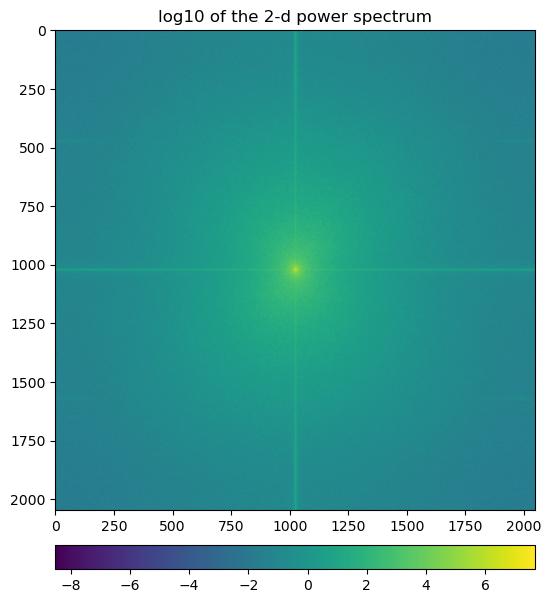

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.set_title("landsat a17")
im0 = ax.imshow(np.log10(spectral_dens))
ax.set_title("log10 of the 2-d power spectrum")
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.35)
out = fig.colorbar(im0, orientation="horizontal", cax=cax)

In [11]:
def graph_spectrum(ax, knum, avg_spec, kol_slope=-5.0 / 3.0, kol_offset=1.0):
    """
       graph the annular average and compare it to Kolmogorov -5/3
    """

    #
    # draw the -5/3 line through a give spot
    #
    kol = kol_offset * (knum ** kol_slope)
    ax.loglog(knum, avg_spec, "r-", label="power")
    ax.loglog(knum, kol, "k-", label="$k^{-5/3}$")
    ax.set(xlabel="k (1/km)", ylabel="$E_k$")
    return ax

In [12]:
avg_binwidth = 5  # make the kradial bins 5 pixels wide


start = timer()
# your code...
end = timer()
print(end - start) # time in seconds
k_bins, avg_spec = annular_avg(spectral_dens, avg_binwidth)

1.2584001524373889e-05
	- INTEGRATING... 
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed


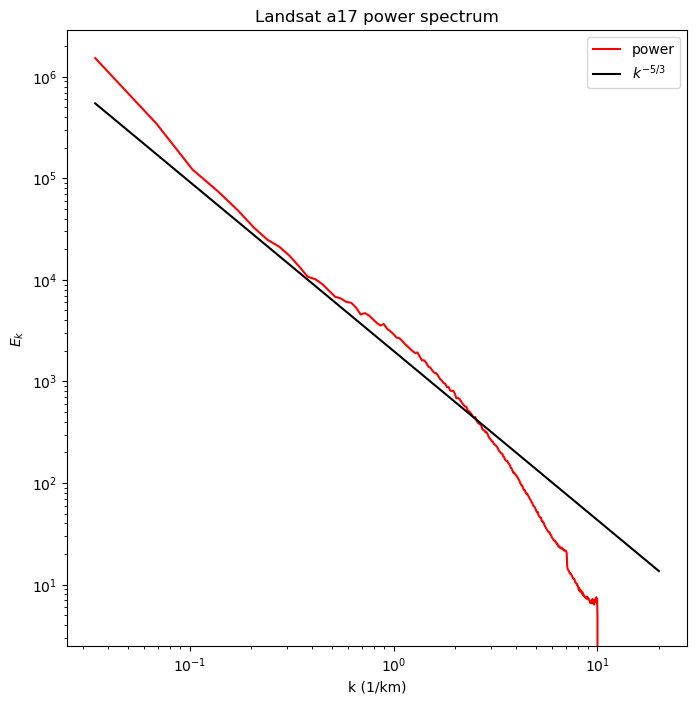

In [13]:
#
# turn the bin numbers into wave numbers for the positive wavenumbs
#
knum = k_bins * (the_fft.nyquist / float(len(k_bins)))  # k = w/(25m)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
the_ax = graph_spectrum(ax, knum, avg_spec, kol_slope=-5 / 3.0, kol_offset=2000.0)
title = f"Landsat {the_fft.filename} power spectrum"
ax.set(title=title, xlabel="k (1/km)", ylabel="$E_k$")
ax.legend()

## Designing a filter

We've got a very similar situation to the fftnotebook.py example, except that rather than oscilating in time for a fixed
location, our Fourier modes are oscillating in space for a fixed time. For spatial oscilations, the equivalent of the frequency
in units of 1/time is the wavenumber, in units of 1/length. Instead of sampling 20.833 time per second, we are
sampling 1000./25 = 40 times per kilometer, i.e our wavenumber sampling rate is 40 $km^{-1}$.  What is the bin resolution
of our sample?  We have 2048 bins in each direction, so each bin represents 40/2048 = 0.0195 $km^{-1}$.  Suppose we want to
filter out all wavenumbers greater than 1/(2 km) = 0.5 $km^{-1}$?  The bin we need to use in our slice is bin 0.5/0.0195 = index 25

### Try a simple round trip with no filter -- do we get the image back?

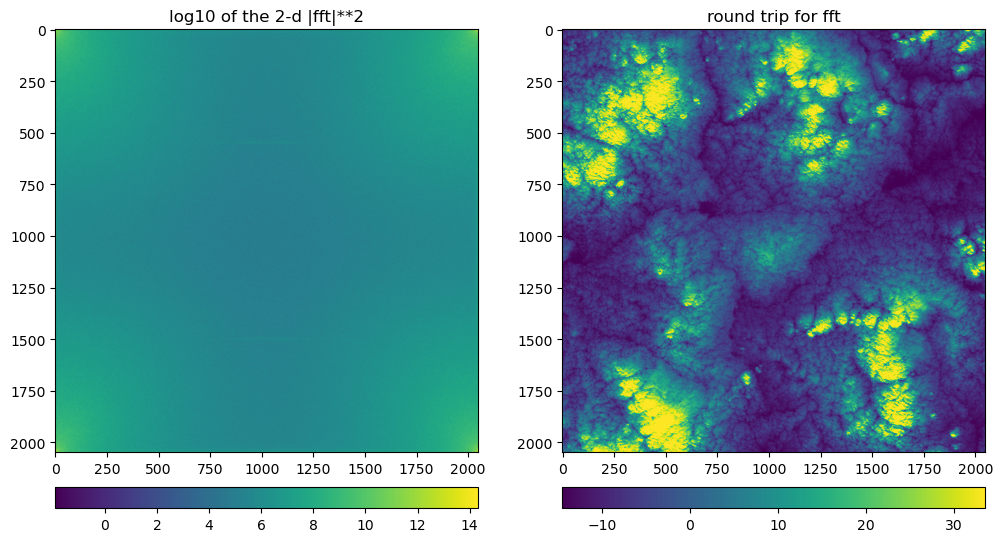

In [14]:
fft2d = the_fft.fft_data
plot_fft = np.real(fft2d * np.conjugate(fft2d))
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].set_title("landsat a17 -- fft")
im0 = ax[0].imshow(np.log10(plot_fft))
ax[0].set_title("log10 of the 2-d |fft|**2")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("bottom", size="5%", pad=0.35)
out = fig.colorbar(im0, orientation="horizontal", cax=cax)

ax[1].set_title("landsat a17 -- fft roundtrip")
invert_fft = fft.ifft2(fft2d)
im1 = ax[1].imshow(np.real(invert_fft))
ax[1].set_title("round trip for fft")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("bottom", size="5%", pad=0.35)
out = fig.colorbar(im1, orientation="horizontal", cax=cax)

## First step

Try just zeroing out all the small wavenumbers in an interior
rectangle and see what happens.  Note how much of the information in the figure is carried by the very narrow frequency banned in the outer frame of the first figure below.  That's where the power is in the spectrum.

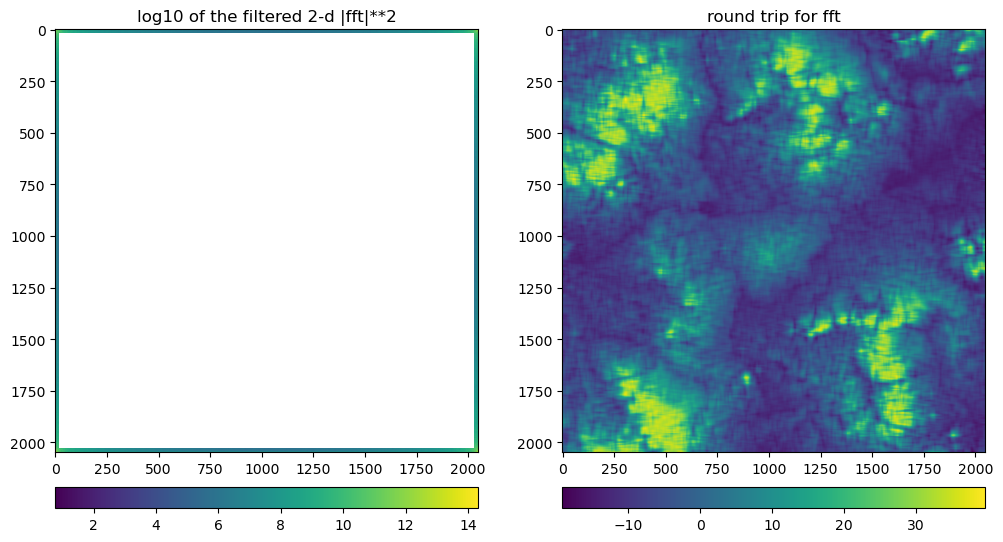

In [15]:
np.seterr(all="ignore")
the_filter = np.zeros_like(plot_fft)
the_filter[0:25, :] = 1  # bottom 25 rows
the_filter[-25:, :] = 1  # top 25 rows
the_filter[:, :25] = 1  # left 25 columns
the_filter[:, -25:] = 1  # right 25 columns
filtered_fft = fft2d * the_filter
plot_fft = np.real(filtered_fft * np.conjugate(filtered_fft))
fig2, ax2 = plt.subplots(1, 2, figsize=(12, 12))
ax2[0].set_title("landsat a17 -- filtered fft")
im0 = ax2[0].imshow(np.log10(plot_fft))
ax2[0].set_title("log10 of the filtered 2-d |fft|**2")
divider = make_axes_locatable(ax2[0])
cax = divider.append_axes("bottom", size="5%", pad=0.35)
out = fig.colorbar(im0, orientation="horizontal", cax=cax)

ax2[1].set_title("landsat a17 -- fft roundtrip")
invert_fft = fft.ifft2(filtered_fft)
im1 = ax2[1].imshow(np.real(invert_fft))
ax2[1].set_title("round trip for fft")
divider = make_axes_locatable(ax2[1])
cax = divider.append_axes("bottom", size="5%", pad=0.35)
out = fig.colorbar(im1, orientation="horizontal", cax=cax)

### Now do this right

Make the filter circular to get the correct wavenumbers, which are given by

$$
k^2 = k_x^2 + k_y^2
$$

Note that you'll have to look
hard in the corners to see the wavenumbers leftover from this filter if you set
the index to 25 or lower.  Look for the tiny blue/green spots in each corner.

In [16]:
#@jit(nopython=True)
def build_filter(the_array, low_pass_index):
    """
    build a low pass filter by setting all
    points less than radius**2. to zero
    """
    height, width = the_array.shape
    center = np.array([int(height / 2.0), int(width / 2.0)])
    #
    # distance from center to one of the corners
    #
    largest_distance = (center[0] ** 2.0 + center[1] ** 2.0) ** 0.5
    radius = largest_distance - low_pass_index  # want all zeros inside this radius
    squared_rad = radius ** 2.0
    filter_array = np.ones_like(the_array)  # start with all ones
    if height != width:
        return None  # require square domain
    for row in range(height):
        for col in range(width):
            coords = np.array([row, col]) - center
            distance = coords[0] ** 2.0 + coords[1] ** 2.0
            if distance < squared_rad:
                filter_array[row, col] = 0.0
    return filter_array

In [17]:
the_filter = build_filter(plot_fft, 25)

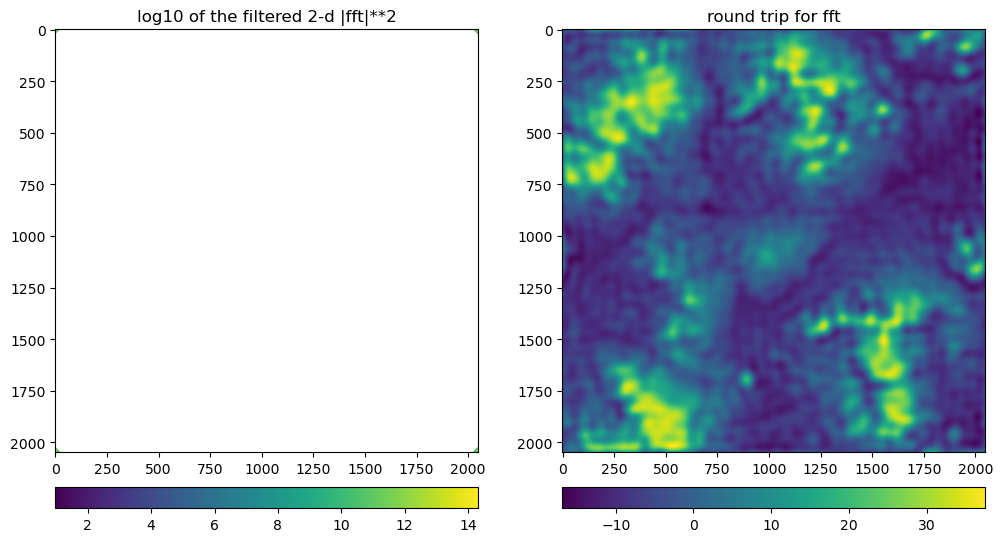

In [18]:
filtered_fft = fft2d * the_filter
plot_fft = np.real(filtered_fft * np.conjugate(filtered_fft))
fig2, ax2 = plt.subplots(1, 2, figsize=(12, 12))
im0 = ax2[0].imshow(np.log10(plot_fft))
ax2[0].set_title("log10 of the filtered 2-d |fft|**2")
divider = make_axes_locatable(ax2[0])
cax = divider.append_axes("bottom", size="5%", pad=0.35)
out = fig.colorbar(im0, orientation="horizontal", cax=cax)

ax2[1].set_title("landsat a17 -- fft roundtrip")
invert_fft = fft.ifft2(filtered_fft)
im1 = ax2[1].imshow(np.real(invert_fft))
ax2[1].set_title("round trip for fft")
divider = make_axes_locatable(ax2[1])
cax = divider.append_axes("bottom", size="5%", pad=0.35)
out = fig.colorbar(im1, orientation="horizontal", cax=cax)

In [19]:
np.log10(plot_fft)

array([[ 0.97037697, 13.20017116, 14.07170378, ..., 12.95310445,
        14.07170378, 13.20017116],
       [13.91524455, 13.12125404, 14.31857431, ..., 12.99293407,
        13.31788193, 13.43526507],
       [13.17647747, 12.12663132, 13.14847959, ..., 13.21702484,
        13.32287604, 13.38876879],
       ...,
       [12.91741145, 11.0308165 , 13.02263172, ..., 12.83790253,
        12.71210948, 13.34895661],
       [13.17647747, 13.38876879, 13.32287604, ..., 13.00559677,
        13.14847959, 12.12663132],
       [13.91524455, 13.43526507, 13.31788193, ..., 12.52723473,
        14.31857431, 13.12125404]])

In [20]:
fft_shift = fft.fftshift(filtered_fft)
new_spectral_dens = fft_shift * np.conjugate(fft_shift) / (the_fft.xdim * the_fft.xdim)
new_spectral_dens = new_spectral_dens.real
start = timer()
k_bins, avg_spec = annular_avg(new_spectral_dens, avg_binwidth)
stop=timer()
print(f"execution time = {stop -start} seconds")

	- INTEGRATING... 
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
		row completed
execution time = 0.035445834015263245 seconds


### The filtered fft

Here is the annually averaged, filtered fft showing that the lowpass filter worked.

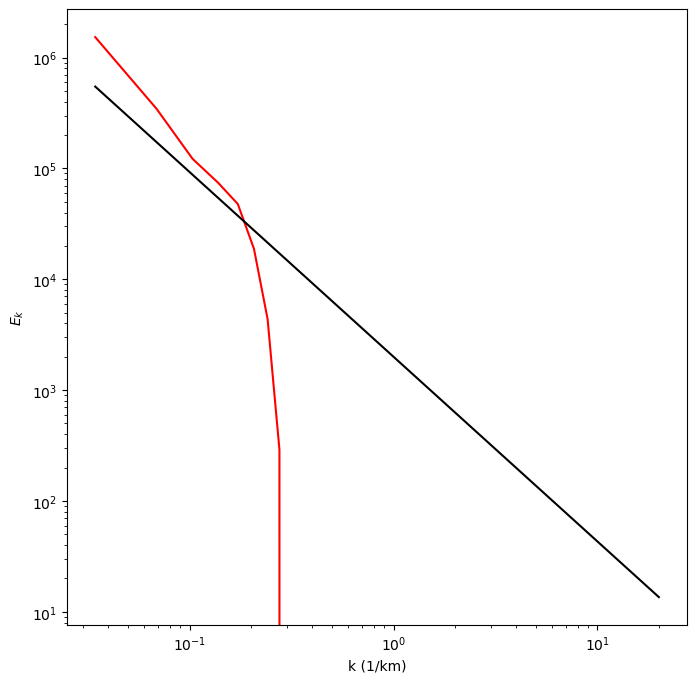

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
the_ax = graph_spectrum(ax, knum, avg_spec, kol_slope=-5 / 3.0, kol_offset=2000.0)
the_ax.set_title = f"Landsat {the_fft.filename} power spectrum"